# Underwater Vehicle Tracking Simulation

This notebook simulates a multi-camera system tracking an underwater vehicle in a water tank using Kalman filters.

In [374]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from filterpy.kalman import KalmanFilter
import seaborn as sns
from scipy.spatial.transform import Rotation as R
from math import pi

# Set random seed for reproducibility
np.random.seed(42)

## 1. Define the Water Tank Environment

In [375]:
class WaterTank:
    def __init__(self, length=1, width=1, height=0.5):
        self.length = length
        self.width = width
        self.height = height
        
    def plot_tank(self, ax):
        # Plot tank boundaries
        x = [0, self.length, self.length, 0, 0]
        y = [0, 0, self.width, self.width, 0]
        z = [0, 0, 0, 0, 0]
        ax.plot(x, y, z, 'b-')
        
        # Plot top surface
        x = [0, self.length, self.length, 0, 0]
        y = [0, 0, self.width, self.width, 0]
        z = [self.height, self.height, self.height, self.height, self.height]
        ax.plot(x, y, z, 'b-')
        
        # Plot vertical edges
        for i in range(4):
            ax.plot([x[i], x[i]], [y[i], y[i]], [0, self.height], 'b-')

## 2. Define the Underwater Vehicle

In [376]:
class UnderwaterVehicle:
    def __init__(self, initial_position, initial_velocity):
        self.position = np.array(initial_position)
        self.velocity = np.array(initial_velocity)
        self.trajectory = [self.position.copy()]
        
    def update(self, dt):
        # Simple motion model with some random movement
        self.position += self.velocity * dt
        self.velocity += np.random.normal(0, 0.01, 3)  # Add some random noise
        self.trajectory.append(self.position.copy())
        
    def plot_vehicle(self, ax):
        ax.scatter(self.position[0], self.position[1], self.position[2], 
                  color='red', s=100, label='Vehicle')
        
        # Plot trajectory
        trajectory = np.array(self.trajectory)
        ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 
                'r--', alpha=0.5, label='Trajectory')

## 3. Define the Camera System

To calculate the image plane position from the world position, we need the following steps:

### Find the relative position of the world point to the camera

$$
\begin{bmatrix} x_{relative} \\ y_{relative} \\ z_{relative} \\ 1 \end{bmatrix} =  P \begin{bmatrix} x_{world} \\ y_{world} \\ z_{world} \\ 1 \end{bmatrix}
$$

Where $P$ is the homogeneous transformation matrix of the camera.

$$P = \begin{bmatrix} c \phi c \theta c\psi - s\phi s\psi & -c \phi c \theta s\psi - s\phi c\psi & c \phi s \theta & -x_{camera} \\ s\phi c \theta c\psi + c\phi s\psi & -s\phi c \theta s\psi + c\phi c\psi & s\phi s \theta & -y_{camera} \\ -s \theta c\psi & s \theta s\psi & c \theta & -z_{camera} \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

### Find the image plane position from the relative position

$$
\lambda \begin{bmatrix} x_{image} \\ y_{image} \\ 1 \end{bmatrix} = \begin{bmatrix} f & 0 & 0 & 0 \\ 0 & f & 0 & 0 \\ 0 & 0 & 1 & 0 \end{bmatrix} \begin{bmatrix} x_{relative} \\ y_{relative} \\ z_{relative} \\ 1 \end{bmatrix}
$$

Where $\lambda$ is an unknown scalar.









In [377]:
class Camera:
    def __init__(self, name, color, position, orientation, focal_length = 0.5, image_plane_size = (1, 1)):
        self.position = np.array(position)
        self.orientation = np.array(orientation)
        self.focal_length = focal_length
        self.image_plane_size = np.array(image_plane_size)
        self.color = color
        self.name = name
        self.P = np.zeros((4, 4))
        self.P[:3, :3] = R.from_euler('xyz', self.orientation, degrees=False).as_matrix()
        self.P[:3, 3] = -self.position
        self.P[3, 3] = 1
        self.trajectory = []
    
    def world2camera(self, world_position):
        world_position_vector = np.array([world_position[0], world_position[1], world_position[2], 1])
        camera_position_vector = self.P @ world_position_vector
        camera_position_vector = np.array([[self.focal_length, 0, 0, 0], [0, self.focal_length, 0, 0], [0, 0, 1, 0]]) @ camera_position_vector

        if camera_position_vector[0] <= -self.image_plane_size[0] / 2 or camera_position_vector[0] > self.image_plane_size[0] / 2:
            return None
        if camera_position_vector[1] <= -self.image_plane_size[1] / 2 or camera_position_vector[1] > self.image_plane_size[1] / 2:
            return None
        return camera_position_vector[:3]
    
    def capture(self, world_position):
        image_position = self.world2camera(world_position)
        if image_position is not None:
            self.trajectory.append(image_position)
    
    def plot_camera(self, ax):
        ax.scatter(self.position[0], self.position[1], self.position[2], 
                  color=self.color, s=100, label=f'Camera {self.name}')
        # Plot camera orientation
        ax.quiver(self.position[0], self.position[1], self.position[2],
                 self.orientation[0], self.orientation[1], self.orientation[2],
                 color=self.color, length=0.1)

    def plot_trajectory(self, ax):
        # Plot the frame of the camera
        ax.plot([self.image_plane_size[0]/2, self.image_plane_size[0]/2],
                [-self.image_plane_size[1]/2, self.image_plane_size[1]/2],
                'g-', alpha=0.5, label='Camera Frame')
        ax.plot([-self.image_plane_size[0]/2, -self.image_plane_size[0]/2],
                [-self.image_plane_size[1]/2, self.image_plane_size[1]/2],
                'g-', alpha=0.5, label='Camera Frame')
        ax.plot([-self.image_plane_size[0]/2, self.image_plane_size[0]/2],
                [-self.image_plane_size[1]/2, -self.image_plane_size[1]/2],
                'g-', alpha=0.5, label='Camera Frame')
        ax.plot([-self.image_plane_size[0]/2, self.image_plane_size[0]/2],
                [self.image_plane_size[1]/2, self.image_plane_size[1]/2],
                'g-', alpha=0.5, label='Camera Frame')
        
        trajectory = np.array(self.trajectory)
        if trajectory.size > 0:
            ax.plot(trajectory[:, 0], trajectory[:, 1],
                    'g--', alpha=0.5, label='Camera Trajectory')

## 4. Implement Kalman Filter

In [378]:
def create_kalman_filter():
    kf = KalmanFilter(dim_x=6, dim_z=3)  # 6 states (position and velocity), 3 measurements
    
    # State transition matrix
    dt = 0.1
    kf.F = np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])
    
    # Measurement matrix
    kf.H = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0]
    ])
    
    # Measurement noise
    kf.R = np.eye(3) * 0.1
    
    # Process noise
    kf.Q = np.eye(6) * 0.1
    
    return kf

## 5. Run Simulation

In [379]:
# Initialize environment
tank = WaterTank()
vehicle = UnderwaterVehicle(initial_position=[0.5, 0.5, 0.25], initial_velocity=[0.005, 0.005, 0.005])

# Initialize cameras
cameras = [
    Camera(name='Camera 1', color='red', position=[0.25, 0.25, -0.25], orientation=[0, 0, pi/2]),
    Camera(name='Camera 2', color='green', position=[0.25, 0.75, -0.25], orientation=[0, 0, pi/2]),
    Camera(name='Camera 3', color='blue', position=[0.75, 0.25, -0.25], orientation=[0, 0, pi/2]),
    Camera(name='Camera 4', color='yellow', position=[0.75, 0.75, -0.25], orientation=[0, 0, pi/2])
]

# Initialize Kalman filter
kf = create_kalman_filter()
kf.x = np.array([1, 1, 1, 0.1, 0.1, 0.1])  # Initial state

# Simulation parameters
dt = 0.1
num_steps = 100

# Storage for results
true_positions = []
estimated_positions = []

# Run simulation
for _ in range(num_steps):
    # Update vehicle position
    vehicle.update(dt)
    true_positions.append(vehicle.position.copy())
    
    # Get observations from all cameras
    for camera in cameras:
        camera.capture(vehicle.position)
    
    # Average observations
    # avg_observation = np.mean(observations, axis=0)
    
    # Update Kalman filter
    # kf.predict()
    # kf.update(avg_observation)
    
    # Store estimated position
    # estimated_positions.append(kf.x[:3])

# Convert to numpy arrays
true_positions = np.array(true_positions)
estimated_positions = np.array(estimated_positions)

## 6. Visualize Results

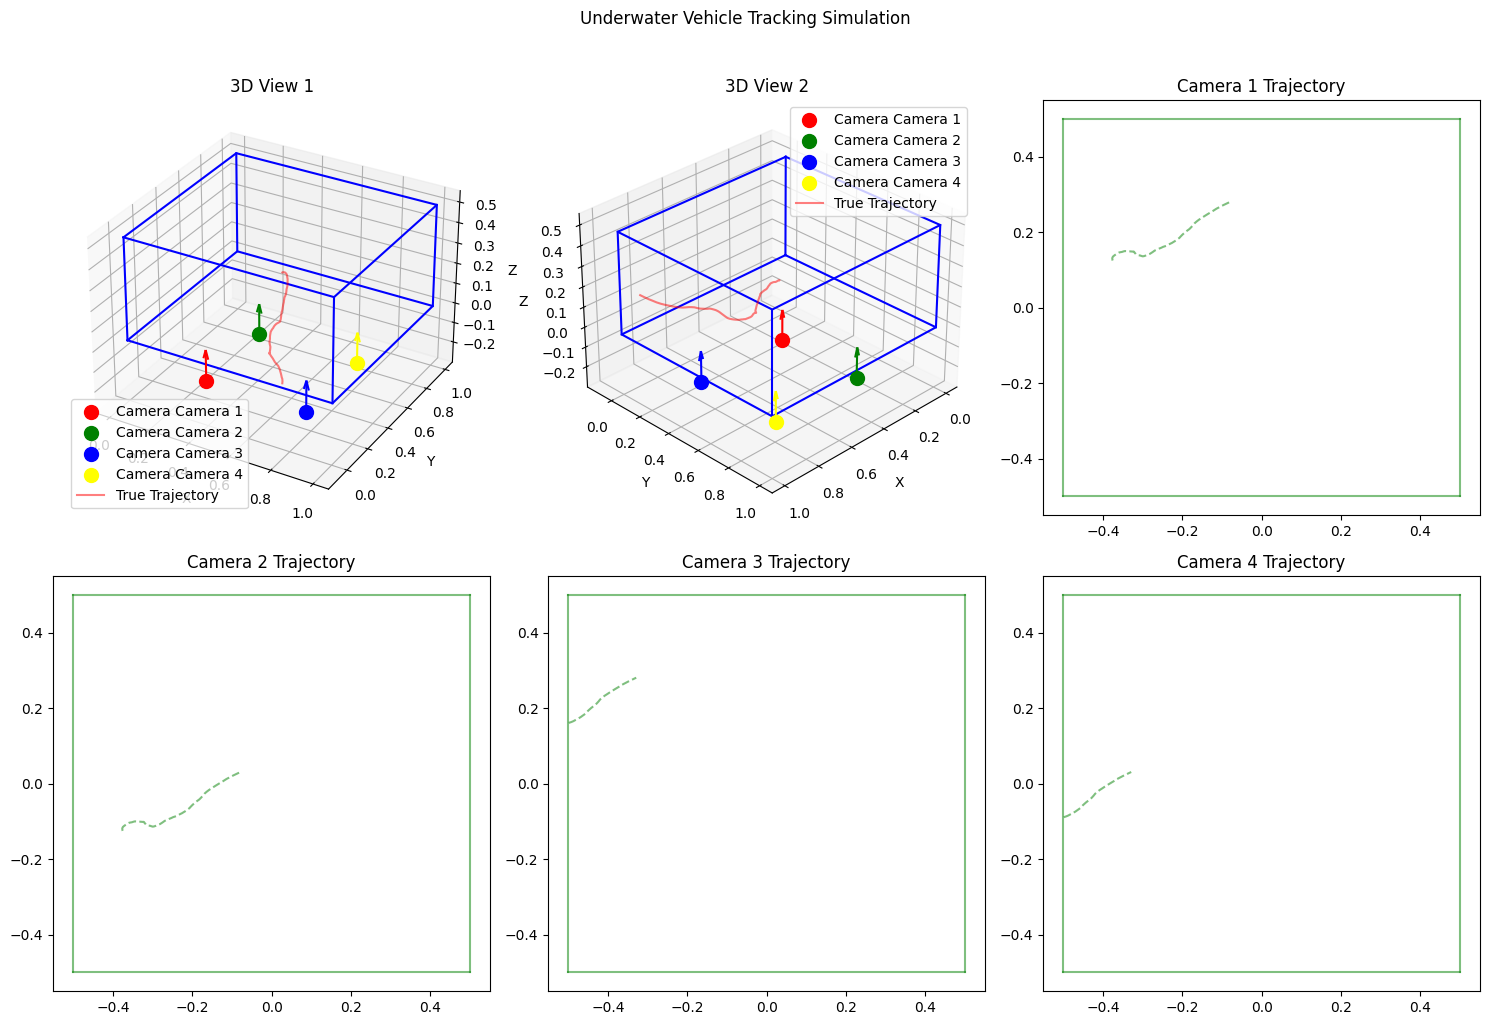

In [380]:
fig = plt.figure(figsize=(15, 10))

# Create a 3x2 grid of subplots
# Main 3D plot in the top left
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
tank.plot_tank(ax1)
for camera in cameras:
    camera.plot_camera(ax1)
ax1.plot(true_positions[:, 0], true_positions[:, 1], true_positions[:, 2], 
        'r-', alpha=0.5, label='True Trajectory')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('3D View 1')

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
tank.plot_tank(ax2)
for camera in cameras:
    camera.plot_camera(ax2)
ax2.plot(true_positions[:, 0], true_positions[:, 1], true_positions[:, 2], 
        'r-', alpha=0.5, label='True Trajectory')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()
ax2.set_title('3D View 2')
# Set a different viewing angle
ax2.view_init(elev=30, azim=45)  # Changed elevation and azimuth angles

# Camera trajectories in remaining subplots
for i, camera in enumerate(cameras):
    ax = fig.add_subplot(2, 3, i+3)  # Start from position 2 in the grid
    camera.plot_trajectory(ax)
    ax.set_title(f'{camera.name} Trajectory')

plt.suptitle('Underwater Vehicle Tracking Simulation', y=1.02)
plt.tight_layout()
plt.show()

## 7. Calculate Tracking Error

In [381]:
# Calculate tracking error
errors = np.linalg.norm(true_positions - estimated_positions, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.xlabel('Time Step')
plt.ylabel('Tracking Error (m)')
plt.title('Tracking Error Over Time')
plt.grid(True)
plt.show()

ValueError: operands could not be broadcast together with shapes (100,3) (0,) 